<a href="https://colab.research.google.com/github/FabioArnez/Simple-Uncertainty-Classification-MCD/blob/master/Uncertainty_Classification_MCD_MNIST_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Classification MCD MNIST

## Check Colab Environment Settings:

__Check GPU availability__

In [2]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-dc8b2566-a1c7-9829-9774-3eaeecda409f)


## Notebook Imports

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

__Check PyTorch Version__

In [4]:
torch.__version__

'1.9.0+cu102'

## MNIST Data

### Data Loader Settings

In [5]:
# number of subprocesses for data loading
num_workers = 2
# how many samples (images) per batch
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2
# train-validation-testing split random seed
dataset_split_seed = 10

### Get MNIST dataset
  1. Get training data
  2. Get testing data

In [9]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# choose the training and test datasets
train_data = torchvision.datasets.MNIST(root='../data', train=True,
                               download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='../data', train=False,
                              download=True, transform=transform)

In [10]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

###  Split the MNIST Dataset

-  Split training data into:
    1. train set
    2. validation set

__obtain training indices that will be used for validation__

In [12]:
num_train = len(train_data)
indices = list(range(num_train))
dataset_split_seed = 10
np.random.seed(dataset_split_seed)
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [13]:
print("Samples Training Data: ", len(train_data))
print("Samples New Training set: ", len(train_idx))
print("Samples New Validation set: ", len(valid_idx))

Samples Training Data:  60000
Samples New Training set:  48000
Samples New Validation set:  12000


__Show the first 10 indices from training set__

In [14]:
train_idx[0:10]

[47819, 40933, 10130, 40589, 20862, 30446, 35098, 53916, 45345, 56376]

__Get subset samplers for obtaining the new training and validation sets__

In [15]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### Get the Dataloaders

1. train loader
2. validation loader
3. test loader

In [16]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [17]:
len(train_loader.dataset)

60000

In [18]:
train_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [19]:
valid_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [20]:
len(valid_loader)

375

### Batch Inspection

__Train Loader Number of Batches__

In [23]:
Batches = len(train_loader)
Batches

1500

In [24]:
len(train_loader.sampler)

48000

In [25]:
dataiter = iter(train_loader)
batch_data, labels = dataiter.next()

In [26]:
batch_data.size()

torch.Size([32, 1, 28, 28])

In [27]:
batch_data.size(0)

32

## Training Routines

### Train

In [36]:
def TrainModel(model, device, train_loader, lossFunction, optimizer):
    sum_traning_batches_avg_loss = 0.0
    # Enable train mode
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = lossFunction(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        sum_traning_batches_avg_loss += loss.item() # sum up batch loss

    return sum_traning_batches_avg_loss

### Validate

In [37]:
def ValidateModel(model, device, valid_loader, lossFunction):
    sum_valid_batches_avg_loss = 0.0
    # Enable train mode
    model.eval()

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = lossFunction(output, target)
            # update running evaluation loss
            sum_valid_batches_avg_loss += loss.item()  # sum up batch loss

    return sum_valid_batches_avg_loss

### Train Test Function

In [43]:
def TrainValidNeuralNet(model, train_loader, valid_loader, num_epochs):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print()    
    print("We are using {}, for training!".format(device))
    print()
    # send nn model to GPU
    model.to(device)
    # specify loss function (categorical cross-entropy)
    # lossFunction = nn.CrossEntropyLoss()
    lossFunction = nn.NLLLoss()
    # specify optimizer
    learning_rate = 0.01
    # specify optimizer (stochastic gradient descent) and learning rate = 0.01
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    epoch_avg_train_losses, epoch_avg_eval_losses = [], []

    for epoch in range(1, num_epochs + 1):
        sum_traning_batches_avg_loss = 0.0
        sum_valid_batches_avg_loss = 0.0

        ###################
        # train the model #
        ###################
        sum_traning_batches_avg_loss = TrainModel(model, device, train_loader, lossFunction, optimizer)
        ######################    
        # validate the model #
        ######################
        sum_valid_batches_avg_loss = ValidateModel(model, device, valid_loader, lossFunction)

        # Get epoch average loss
        epoch_avg_train_loss = sum_traning_batches_avg_loss / len(train_loader)
        epoch_avg_valid_loss = sum_valid_batches_avg_loss / len(valid_loader)

        # append epoch average losses
        epoch_avg_train_losses.append(epoch_avg_train_loss)
        epoch_avg_eval_losses.append(epoch_avg_valid_loss)

        print("Epoch: {}/{}.. ".format(epoch, num_epochs),
          "Avg. Training Loss: {:.3f}.. ".format(epoch_avg_train_loss),
          "Avg. Validation Loss: {:.3f}.. ".format(epoch_avg_valid_loss))

    return epoch_avg_train_losses, epoch_avg_eval_losses

## Simple Neural Network with Droput

### Create Neural Network Model

In [46]:
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # # flatten image input
        x = x.view(-1, 28 * 28)
        # Now with dropout
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        output = F.log_softmax(x, dim=1)
        return output

In [47]:
# initialize the NN
model = FullyConnectedNet()
print(model)

FullyConnectedNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Train & Evaluate Neural Network

In [45]:
epoch_train_losses, epoch_eval_losses = [], []
epoch_train_losses, epoch_eval_losses = TrainValidNeuralNet(model, train_loader, valid_loader, 5)


We are using cuda, for training!

Epoch: 1/5..  Avg. Training Loss: 0.059..  Avg. Validation Loss: 0.091.. 
Epoch: 2/5..  Avg. Training Loss: 0.054..  Avg. Validation Loss: 0.084.. 
Epoch: 3/5..  Avg. Training Loss: 0.050..  Avg. Validation Loss: 0.082.. 
Epoch: 4/5..  Avg. Training Loss: 0.046..  Avg. Validation Loss: 0.083.. 
Epoch: 5/5..  Avg. Training Loss: 0.044..  Avg. Validation Loss: 0.082.. 


__Save de Model__

In [48]:
torch.save(model.state_dict(), 'model.pt')

### Plot Training and Validation Loss

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

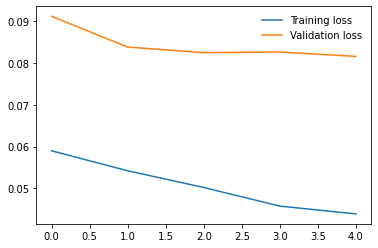

In [50]:
plt.plot(epoch_train_losses, label='Training loss')
plt.plot(epoch_eval_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Simple Neural Network with Dropout (MCD)

### Create Neural Network Model Dropout

In [51]:
# initialize the NN
model_dropout = FullyConnectedNetDropOut()
print(model)

FullyConnectedNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Train & Evaluate Neural Network

In [54]:
epoch_train_losses, epoch_eval_losses = [], []
epoch_train_losses, epoch_eval_losses = TrainValidNeuralNet(model_dropout, train_loader, valid_loader, 5)


We are using cuda, for training!

Epoch: 1/5..  Avg. Training Loss: 1.071..  Avg. Validation Loss: 0.537.. 
Epoch: 2/5..  Avg. Training Loss: 0.513..  Avg. Validation Loss: 0.340.. 
Epoch: 3/5..  Avg. Training Loss: 0.372..  Avg. Validation Loss: 0.262.. 
Epoch: 4/5..  Avg. Training Loss: 0.287..  Avg. Validation Loss: 0.212.. 
Epoch: 5/5..  Avg. Training Loss: 0.233..  Avg. Validation Loss: 0.175.. 


__Save the model__

In [34]:
torch.save(model.state_dict(), 'model-dropout.pt')

### Plot Training and Validation Loss

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

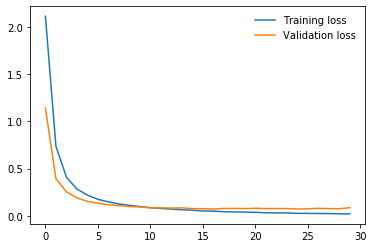

In [ ]:
plt.plot(epoch_train_losses, label='Training loss')
plt.plot(epoch_eval_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Model Test and Compare

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# create iterator
dataiter = iter(test_loader)
# Get batch samples and labels
batch_images, batch_labels = dataiter.next()

batch_images_samples = batch_images.to(device)
batch_labels_samples = batch_labels.to(device)

### Test Model without MCD

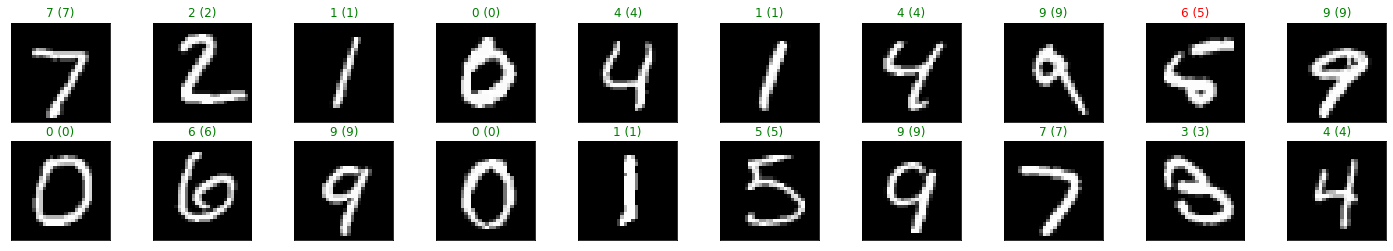

In [ ]:
# get sample outputs
output = model_dropout(batch_images_samples)
# convert output probabilities to predicted class,
# get argmax
_, preds = torch.max(output, 1)
# prep images for display
images = batch_images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(batch_labels[idx].item())),
                 color=("green" if preds[idx]==batch_labels[idx] else "red"))

### Test Model with MCD

__Enable dropout during testing__

In [ ]:
def apply_dropout(m):
    if type(m) == nn.Dropout:
        m.train()

In [ ]:
# Apply dropout on testing 
model_dropout.apply(apply_dropout)

FullyConnectedNetDropOut(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout_02): Dropout(p=0.2, inplace=False)
  (dropout_04): Dropout(p=0.4, inplace=False)
)

__Define the Number of Stochastic Forward passes for each input sample__

In [ ]:
# Nro of Forward passes
T = 20
predictions = []

#### Input Sample with Correct Prediction

__Use the same batch__

Use image[0] from batch, which has label "7"

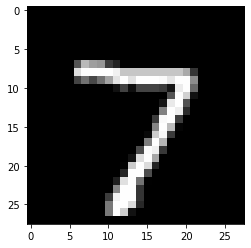

In [ ]:
batch_image_sample = batch_images[0].to(device)
batch_label_sample = batch_labels[0].to(device)
# Plot one sample of the batch
img = np.array(batch_image_sample, dtype='float')
img = img.reshape((28, 28))

plt.imshow(img, cmap='gray')
plt.show()

__Run 20 Stochastic Forward Passes__

In [ ]:
predictions = [np.exp(model_dropout(batch_images[0]).detach().numpy()).argmax() for t in range(T)]
predictions

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

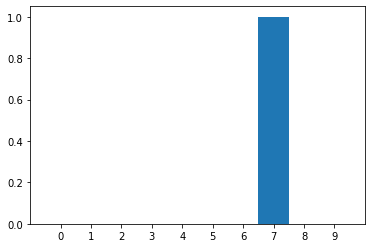

In [ ]:
# Plot predictions histogram
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.hist(predictions, range=(0,10), align='left', density=True)
plt.xticks(bins)
plt.show()

In [ ]:
counts, bins = np.histogram(predictions, bins=10, range=(0,10), density=True)
counts, bins

(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

#### Input Sample with Wrong Prediction

Use the same batch

Use image[8] from batch, which has label "5" but was misclassified as "6"

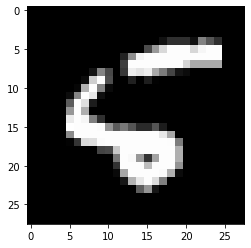

In [ ]:
batch_image_sample_8 = batch_images[8].to(device)
batch_label_sample_8 = batch_labels[8].to(device)
# Plot one sample of the batch
img = np.array(batch_image_sample_8, dtype='float')
img = img.reshape((28, 28))

plt.imshow(img, cmap='gray')
plt.show()

__Run 20 Stochastic Forward Passes__

In [ ]:
predictions = [np.exp(model_dropout(batch_images[8]).detach().numpy()).argmax() for t in range(T)]
predictions

[6, 6, 6, 6, 6, 5, 5, 5, 6, 4, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6]

__Plot Predictions Histogram__

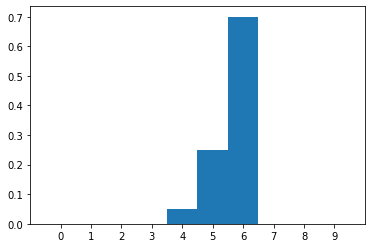

In [ ]:
# Plot predictions histogram
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.hist(predictions, range=(0,10), align='left', density=True)
plt.xticks(bins)
plt.show()

The Neural Net gets confused between labels "4" and "6"

#### Input Sample that is Intentionally Out-Of-Distribution (ODD)

__Use the same batch__

Use image[0] from batch, which has label "7" but this time perform the __transpose__ on that image

This operation allows to input an unknown sample to the model (i.e. transposed sample with "7" label).

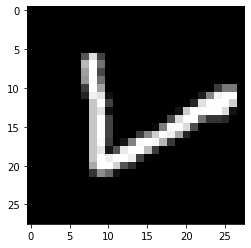

In [ ]:
batch_images_samples = batch_images.to(device)
batch_labels_samples = batch_labels.to(device)
# Plot one sample of the batch
#Get sample transpose
batch_image_sample_0_T = batch_image_sample_0.T
# Plot one sample of the batch
img = np.array(batch_image_sample_0_T, dtype='float')
img = img.reshape((28, 28))

plt.imshow(img, cmap='gray')
plt.show()

__Run 20 Stochastic Forward Passes__

Fix tensor dimensions and turn tensor into contiguous after transpose operation
[Contigious vs non-contigious tensor](https://discuss.pytorch.org/t/contigious-vs-non-contigious-tensor/30107)

In [ ]:
#Get sample transpose
imageTransposed = batch_images[0].T.contiguous()
imageTransposed = imageTransposed.to(device)

In [ ]:
predictions = [np.exp(model_dropout(imageTransposed).detach().numpy()).argmax() for t in range(T)]
predictions

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

__Plot Predictions Histogram__

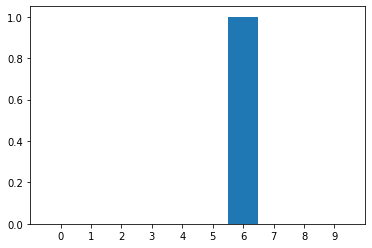

In [ ]:
# Plot predictions histogram
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.hist(predictions, range=(0,10), align='left', density=True)
plt.xticks(bins)
plt.show()

The neural networks is totally sure that this input (ODD input) is a "6"

This is very dangerous, the NN is totally confident about something we don't know for sure